In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import models_mae

### Define utils

In [12]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_model_ImNet(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)
    return model

def prepare_model_from_torchhub(model_name='deit_base_patch16_224'):
    model = torch.hub.load('facebookresearch/deit:main', model_name)
    return model



def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [3]:
torch.device("cuda:1")

device(type='cuda', index=1)

### Load an image

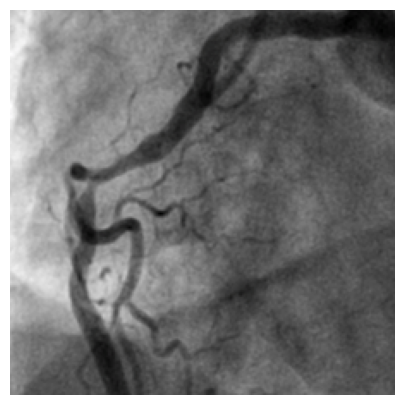

In [3]:
# load an image
img_url = './FAME2_data/FOLD_0/train/VOCE_0/110.png' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img)[:,:,:3] / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [11]:
chkpt_dir_vit_imNet = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/vit_large_patch16_224.pth'
arch = 'mae_vit_large_patch16'

model = getattr(models_mae, arch)()
# load model
checkpoint = torch.load(chkpt_dir_vit_imNet, map_location='cpu')
msg = model.load_state_dict(checkpoint, strict=False)
print(msg)

_IncompatibleKeys(missing_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'decoder_blocks.2.norm1.bias', 'decoder_bl

In [10]:
checkpoint.keys()

odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

In [31]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
chkpt_dir_cfp = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_cfp_weights.pth'
chkpt_dir_xca = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_xca_weights.pth'
chkpt_dir_fame2 = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_fame2_weights.pth'
chkpt_dir_imNet = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/mae_visualize_vit_large.pth'
chkpt_dir_imNet_fame2 = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/output_dir_pretrain_ImNet/checkpoint-300.pth'

model_mae_cfp = prepare_model(chkpt_dir_cfp, 'mae_vit_large_patch16')
model_dir_xca = prepare_model(chkpt_dir_xca, 'mae_vit_large_patch16')
model_mae_fame2 = prepare_model(chkpt_dir_fame2, 'mae_vit_large_patch16')
model_vit_imNet = prepare_model(chkpt_dir_imNet, 'mae_vit_large_patch16')
model_vit_imNet_fame2 = prepare_model(chkpt_dir_imNet_fame2, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


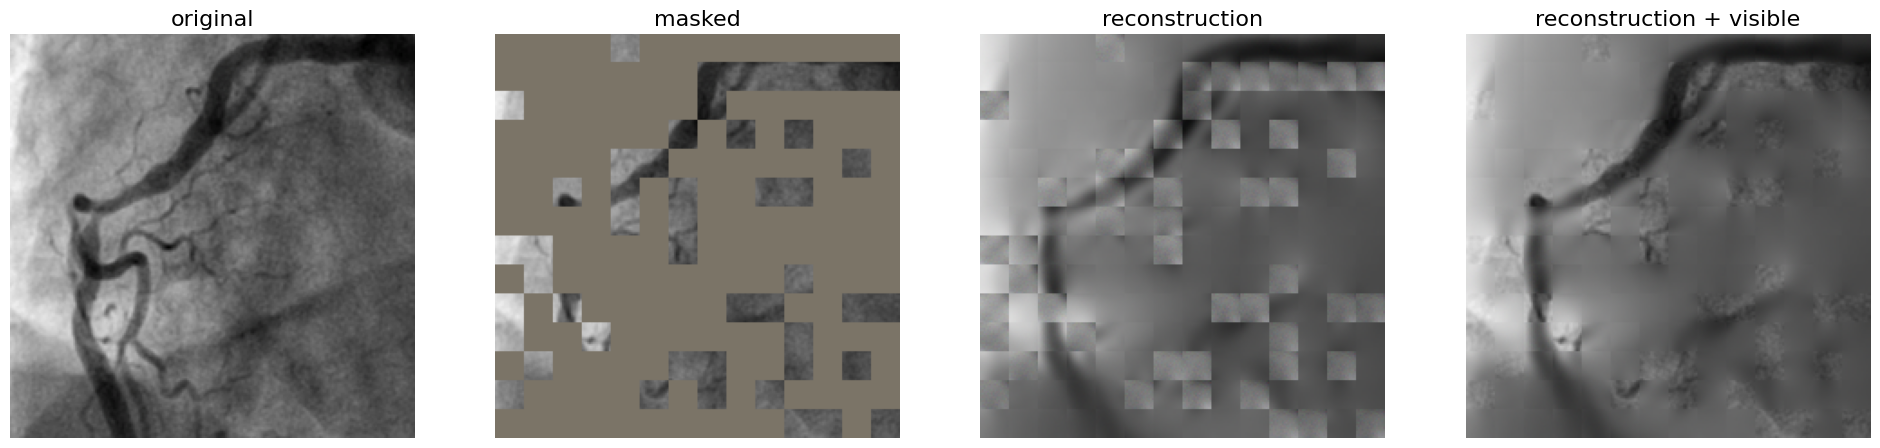

In [35]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(10)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_fame2)

MAE with pixel reconstruction:


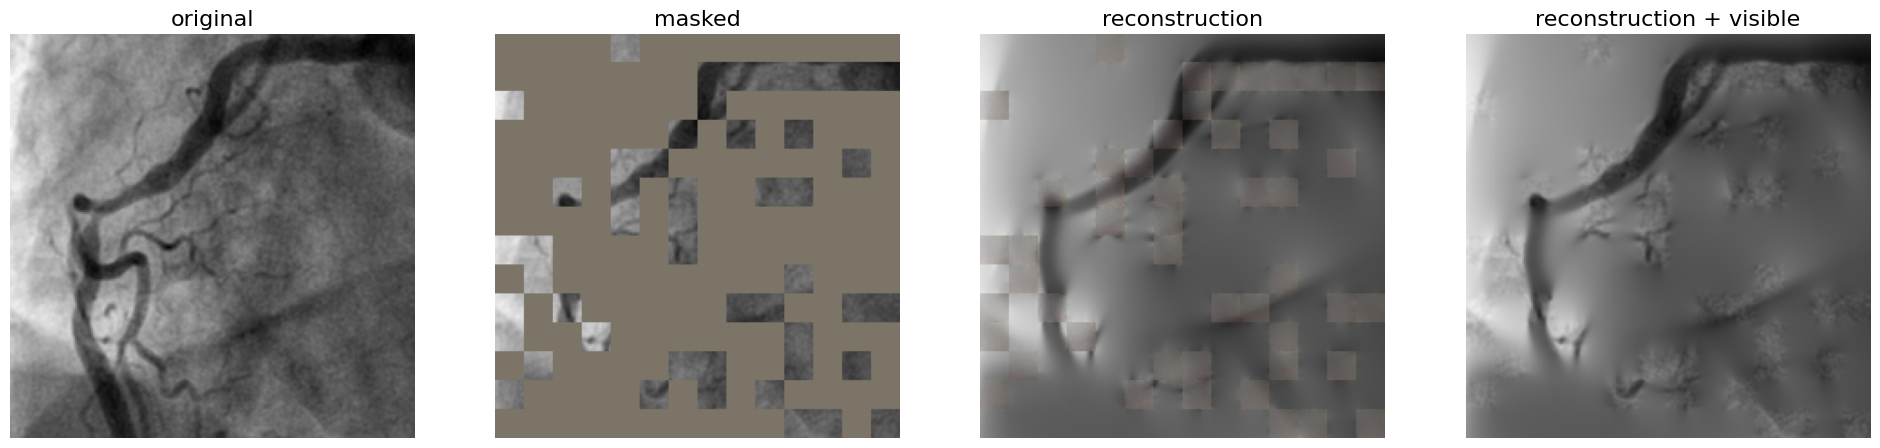

In [33]:
torch.manual_seed(10)
print('MAE with pixel reconstruction:')
run_one_image(img, model_vit_imNet)

MAE with pixel reconstruction:


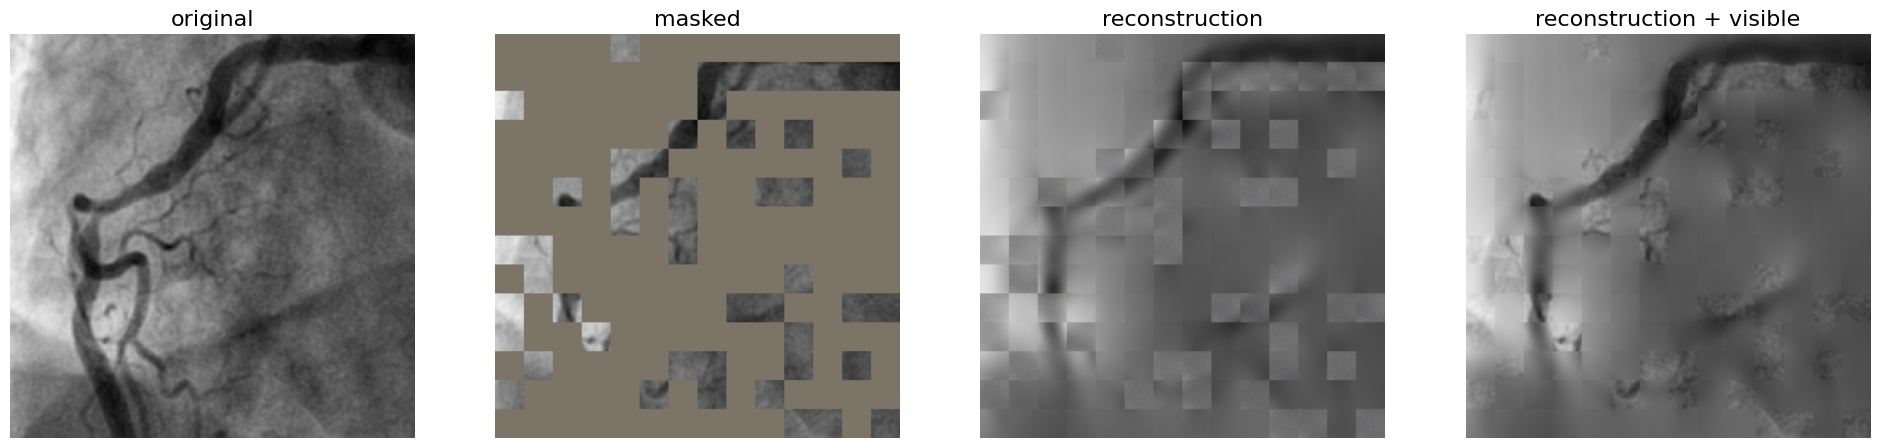

In [34]:
torch.manual_seed(10)
print('MAE with pixel reconstruction:')
run_one_image(img, model_vit_imNet_fame2)

MAE with pixel reconstruction:


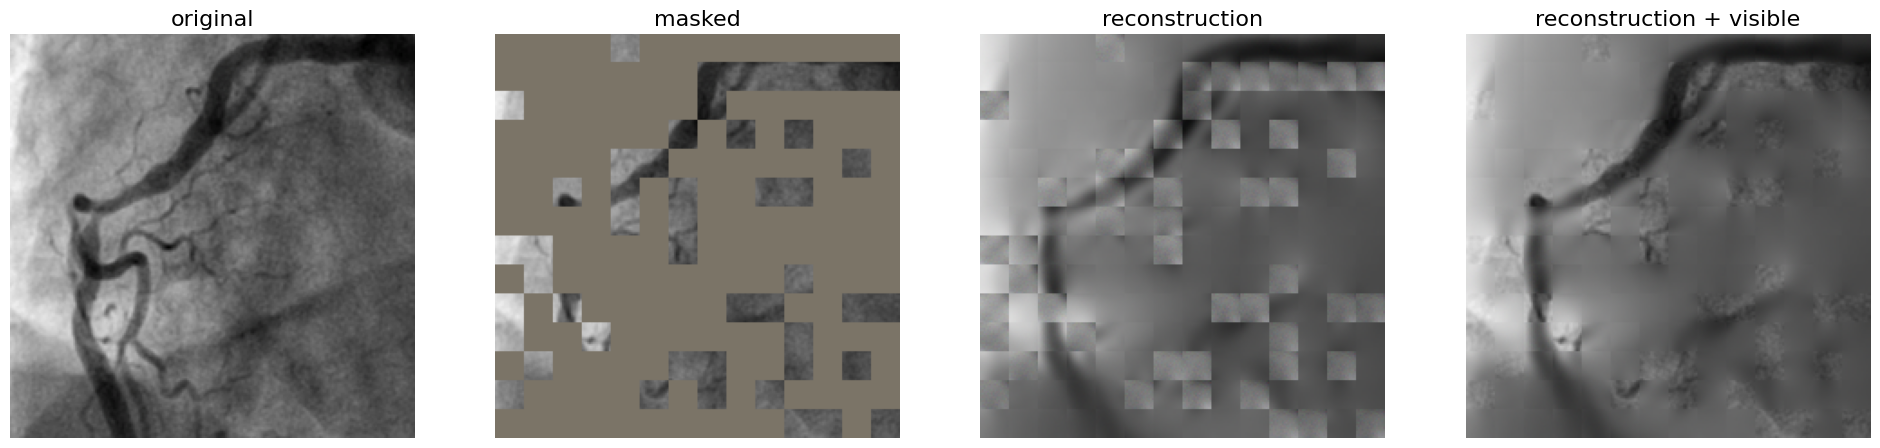

In [11]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(10)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_fame2)

MAE with pixel reconstruction:


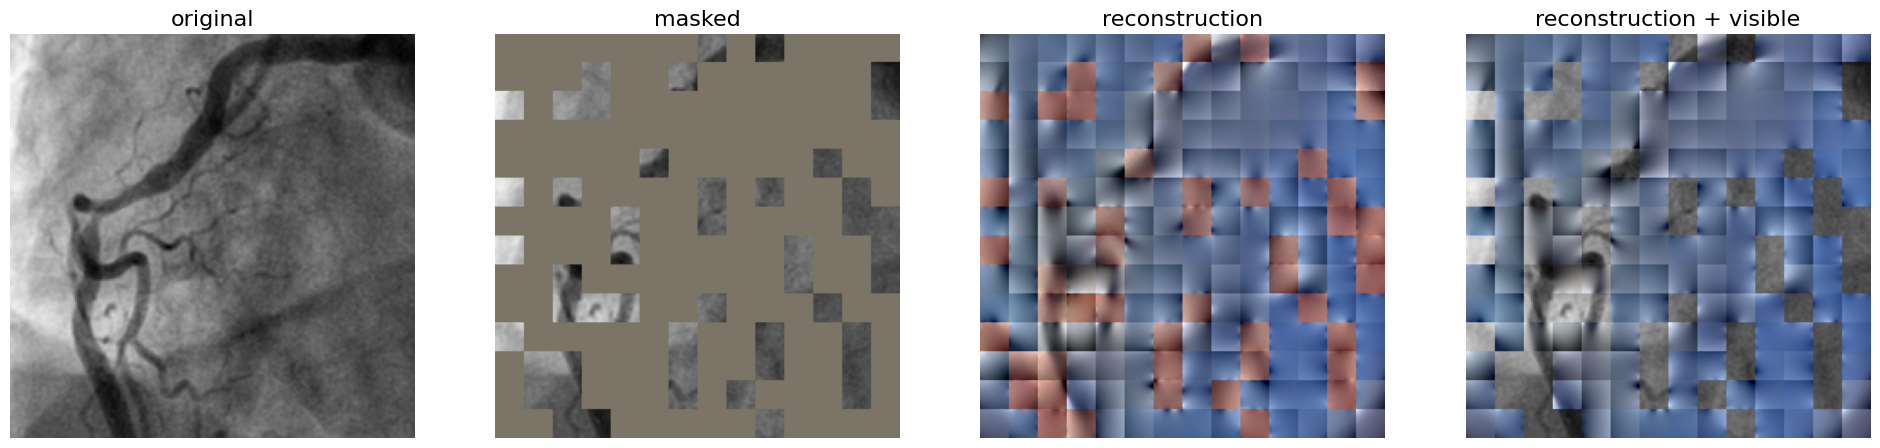

In [12]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_cfp)

MAE with pixel reconstruction:


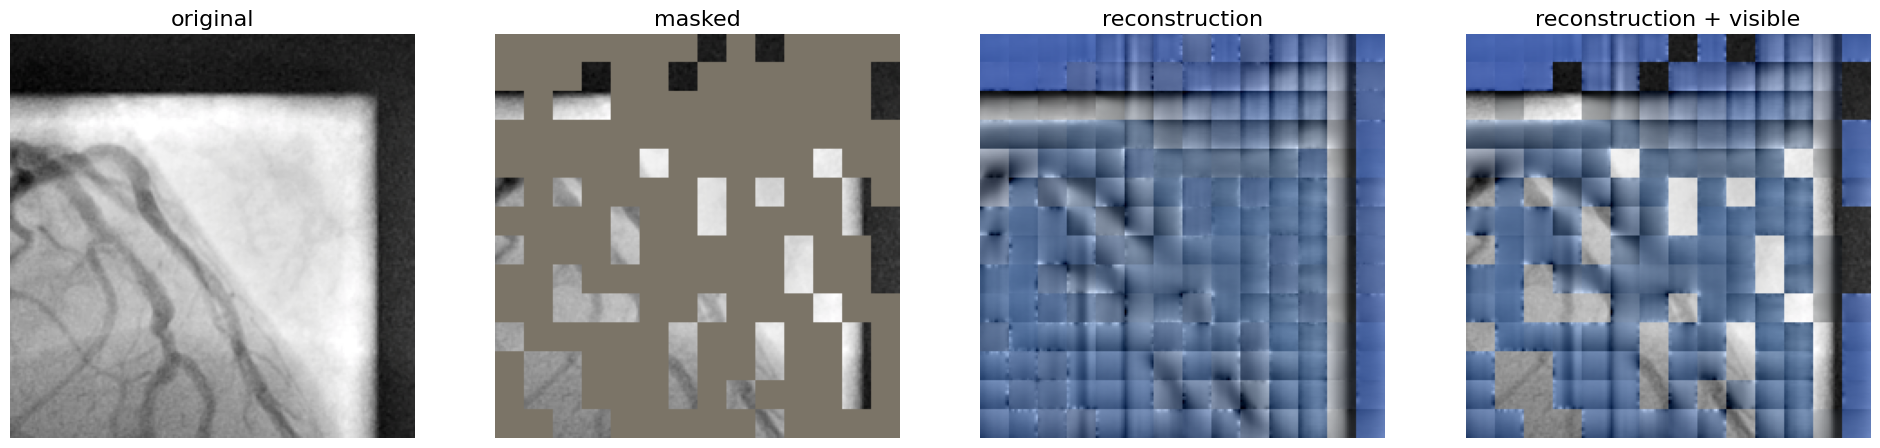

In [13]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_oct)

### Dataset for finetune

In [1]:
import pandas as pd
import shutil
import os

In [2]:
def delete_if_exists(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

In [5]:
for fold in range(3):
    list_train = pd.read_csv(f'/data/mkondrac/foundation_model_cardio/code/Foundation-Medical/storage/FAME2/FOLD_{fold}/train.csv')
    list_val = pd.read_csv(f'/data/mkondrac/foundation_model_cardio/code/Foundation-Medical/storage/FAME2/FOLD_{fold}/val.csv')
    VOCE0_train = list_train.loc[list_train['label']==0]
    VOCE1_train = list_train.loc[list_train['label']==1]
    VOCE0_val = list_val.loc[list_val['label']==0]
    VOCE1_val = list_val.loc[list_val['label']==1]
    VOCE0_test= list_val.loc[list_val['label']==0]
    VOCE1_test = list_val.loc[list_val['label']==1]

    path_to_FAME2_unbalanced = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/FAME2_data_augmented'
    path_to_FAME2_balanced = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/FAME2_data'

    path_list=[path_to_FAME2_unbalanced, path_to_FAME2_balanced]
    split_list = ["train", "val","test"]
    VOCE_list=["VOCE_0", "VOCE_1"]

    data_dict = {
        ("train", "VOCE_0"): VOCE0_train,
        ("train", "VOCE_1"): VOCE1_train,
        ("val", "VOCE_0"): VOCE0_val,
        ("val", "VOCE_1"): VOCE1_val,
        ("test", "VOCE_0"): VOCE0_test,
        ("test", "VOCE_1"): VOCE1_test,
    }

    for path in path_list:
        for split in split_list:
            for voce in VOCE_list:
                delete_if_exists(os.path.join(path, f"FOLD_{fold}", split, voce))

    for j, path in enumerate(path_list):
        for split in split_list:
            for k, voce in enumerate(VOCE_list):
                data = data_dict.get((split, voce))
                if data is not None:
                    i=0
                    for p in data['img_path']:
                        if split=='val' or split=='test' or j==1: # original dataset case
                            if int(p.split('/')[-1].split('_')[2].split('.')[0])==0:
                                shutil.copy(p, os.path.join(path,  f"FOLD_{fold}", split, voce, f'{i}.png'))
                                i+=1
                        else :
                            shutil.copy(p, os.path.join(path, f"FOLD_{fold}", split, voce, f'{i}.png'))
                            i+=1